# Clustering as means of improving model

The performance for timeslot prediction training with Logistic regression and ensemble methods are not good, with less than 0.5 accuracy. We aim to improve the time slot better by first using clustering methods to identify the clusters, rather than using area based training.

## Loading the libraries

In [2]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import folium
from folium.plugins import HeatMap, MarkerCluster, AntPath
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter, label
from kmodes.kprototypes import KPrototypes
import joblib

In [3]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils, genetic_algo

## Load data

In [4]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"
spark = utils.start_spark()
df = utils.prepare_data(spark, data_path)
df = utils.feature_engineering(df)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/09 23:04:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/09 23:04:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/09 23:04:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [5]:
print(df.columns)

['Date Rptd', 'Date OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION', 'LAT', 'LON', 'Occ DateTime', 'hour', 'time_slot', 'Year OCC', 'Month OCC', 'Day OCC', 'age_group', 'Category']


In [6]:
columns = ['Date Rptd', 'Date OCC', 'TIME OCC', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION', 'Occ DateTime', 'age_group']
df_clean = utils.drop_columns(df, columns)

In [7]:
df_clean.show()

+----+--------+--------+--------------------+-------+---------+----+---------+--------+---------+-------+------------------+
|AREA|Vict Age|Vict Sex|        Vict Descent|    LAT|      LON|hour|time_slot|Year OCC|Month OCC|Day OCC|          Category|
+----+--------+--------+--------------------+-------+---------+----+---------+--------+---------+-------+------------------+
|   1|      47|       M|               Other|34.0444|-118.2628|  18|        3|    2020|        2|      7|              BTFV|
|   3|      19|       X|             Unknown| 34.021|-118.3002|  17|        3|    2020|       11|      4|       OTHER THEFT|
|   9|      19|       M|               Other|34.1576|-118.4387|  20|        3|    2020|        3|      3|       OTHER THEFT|
|   6|      28|       M|Hispanic/Latin/Me...|34.0944|-118.3277|  12|        2|    2020|        8|      2|    IDENTITY THEFT|
|  18|      41|       M|Hispanic/Latin/Me...|33.9467|-118.2463|  23|        3|    2020|       12|      3|    IDENTITY THEFT|


24/11/09 23:04:48 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Using KPrototypes for K-Means
The K-prototypes algorithm is an extension of K-means that can handle both categorical and numerical data. It uses a combination of the Euclidean distance for continuous features and Hamming distance for categorical features.

In [8]:
df_pd = df_clean.toPandas()


In [9]:
df_pd.head()

,AREA,Vict Age,Vict Sex,Vict Descent,LAT,LON,hour,time_slot,Year OCC,Month OCC,Day OCC,Category
0,1,47,M,Other,34.0444,-118.2628,18,3,2020,2,7,BTFV
1,3,19,X,Unknown,34.0210,-118.3002,17,3,2020,11,4,OTHER THEFT
2,9,19,M,Other,34.1576,-118.4387,20,3,2020,3,3,OTHER THEFT
3,6,28,M,Hispanic/Latin/Mexican,34.0944,-118.3277,12,2,2020,8,2,IDENTITY THEFT
4,18,41,M,Hispanic/Latin/Mexican,33.9467,-118.2463,23,3,2020,12,3,IDENTITY THEFT


In [11]:
categorical_columns = ["Vict Sex", "Vict Descent", "Category", "time_slot"]
numerical_columns = ["AREA", "Vict Age", "LAT", "LON", "hour", "Year OCC", "Month OCC", "Day OCC"]
df_pca = df_pd.copy()
df_pca[categorical_columns] = df_pca[categorical_columns].astype(str)
for col in numerical_columns:
    df_pca[col] = pd.to_numeric(df_pca[col], errors='coerce')
    df_pca[col] = StandardScaler().fit_transform(df_pca[[col]])
print(df_pca.shape)
df_pca = df_pca.dropna()
print(df_pca.shape)


(721201, 12)
(721201, 12)


## PCA
Do PCA to reduce dimensionality

In [12]:
df_encoded = pd.get_dummies(df_pca, columns=categorical_columns)

In [13]:
scaler = StandardScaler()
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

In [14]:
pca = PCA()
pca_data = pca.fit_transform(df_encoded)

In [15]:
# Get explained variance ratios and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Identify number of components for 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to reach 90% variance: {n_components_90}")

# Extract loadings for these components
loadings = pca.components_[:n_components_90]

# Sum absolute loadings for each feature across selected components
feature_contributions = np.sum(np.abs(loadings), axis=0)
feature_contribution_df = pd.DataFrame({
    'Feature': df_encoded.columns,
    'Contribution': feature_contributions
})

# Rank features by their contribution
feature_contribution_df = feature_contribution_df.sort_values(by='Contribution', ascending=False)
print("Feature contributions to 90% variance:\n", feature_contribution_df)

Number of components to reach 90% variance: 13
Feature contributions to 90% variance:
                                         Feature  Contribution
2                                           LAT      2.240177
3                                           LON      2.097134
0                                          AREA      2.064141
1                                      Vict Age      1.987775
29                           Vict Descent_White      1.654227
5                                      Year OCC      1.621919
6                                     Month OCC      1.583012
19          Vict Descent_Hispanic/Latin/Mexican      1.551448
7                                       Day OCC      1.543202
13                           Vict Descent_Black      1.305858
34                                Category_BTFV      1.285599
4                                          hour      1.273140
52                                  time_slot_2      1.221346
8                                    Vict Sex

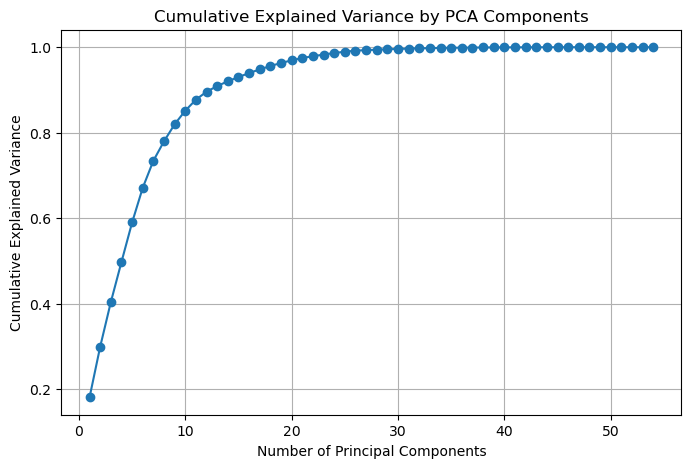

In [16]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [17]:
components_90_variance = np.where(cumulative_variance >= 0.90)[0][0] + 1

print("Number of components contributing to 90% variance:", components_90_variance)

Number of components contributing to 90% variance: 13


In [18]:
df_pd.to_pickle("clusters/data_for_time_slot_clustering.pkl")

## K-Means clustering with K-Prototypes

After identifying the top features, we reduce the dimensionality by using only the top 6 features which are - "Vict Age", "LAT", "LON", "Day OCC", "Month OCC", and "AREA"

In [19]:
features = ["Vict Age", "LAT", "LON", "AREA", "Month OCC", "Day OCC", "hour", "time_slot"]
df_clustering = df_pd[features]
df_clustering.head()

,Vict Age,LAT,LON,AREA,Month OCC,Day OCC,hour,time_slot
0,47,34.0444,-118.2628,1,2,7,18,3
1,19,34.0210,-118.3002,3,11,4,17,3
2,19,34.1576,-118.4387,9,3,3,20,3
3,28,34.0944,-118.3277,6,8,2,12,2
4,41,33.9467,-118.2463,18,12,3,23,3


In [31]:
# another clustering
features = ["Vict Age", "LAT", "LON", "AREA", "Month OCC", "Day OCC"]
df_clustering_1 = df_pd[features]
df_clustering_1.head()


,Vict Age,LAT,LON,AREA,Month OCC,Day OCC
0,47,34.0444,-118.2628,1,2,7
1,19,34.0210,-118.3002,3,11,4
2,19,34.1576,-118.4387,9,3,3
3,28,34.0944,-118.3277,6,8,2
4,41,33.9467,-118.2463,18,12,3


In [32]:
kmeans_1 = KMeans(n_clusters=25, random_state=42)
kmeans_1.fit(df_clustering_1)
df_clustering_1["cluster"] = kmeans_1.labels_
df_clustering_1.shape

/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_79705/3731738208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering_1["cluster"] = kmeans_1.labels_


(721201, 7)

In [30]:
joblib.dump(kmeans_1, "clusters/kmeans_without_hr_model.pkl")

['clusters/kmeans_without_hr_model.pkl']

In [21]:

wcss = []  # List to store WCSS for each k
# Loop through a range of k values
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clustering)  # Fit K-means
    wcss.append(kmeans.inertia_)
    


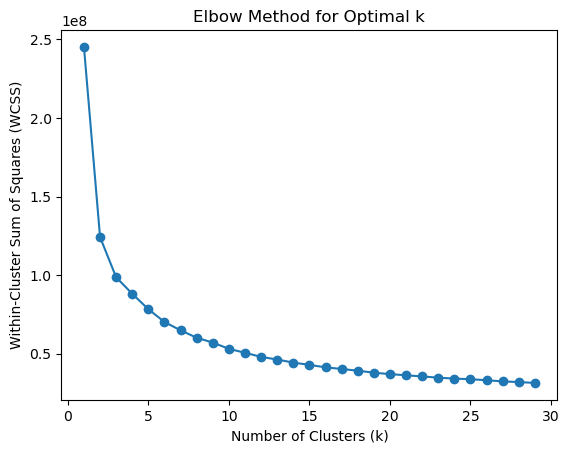

In [22]:
# Plotting the WCSS values for each k
plt.plot(range(1, 30), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [26]:
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(df_clustering)
df_clustering["cluster"] = kmeans.labels_
df_clustering.shape


/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_79705/2066488329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering["cluster"] = kmeans.labels_


(721201, 9)

In [48]:
df_clustering.to_pickle("pickles/clusters_kmeans_overall.pkl")

In [49]:
joblib.dump(kmeans, "models/kmeans_overall.pkl")

['models/kmeans_overall.pkl']

In [30]:
# K-Prototypes clustering (specify categorical columns by index)
kproto = KPrototypes(n_clusters=10, init='Cao', n_init=5, verbose=2)
clusters = kproto.fit_predict(df_pd, categorical=[2, 3, 10])  # 1 is the index of the categorical column
print(clusters)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 222321, ncost: 4126371.189058462
Run: 1, iteration: 2/100, moves: 106174, ncost: 4071318.644589455
Run: 1, iteration: 3/100, moves: 90319, ncost: 4012188.8036460606
Run: 1, iteration: 4/100, moves: 72932, ncost: 3982875.5552261556
Run: 1, iteration: 5/100, moves: 47268, ncost: 3970089.1793370876
Run: 1, iteration: 6/100, moves: 36049, ncost: 3960294.8381863656
Run: 1, iteration: 7/100, moves: 24576, ncost: 3956188.192923249
Run: 1, iteration: 8/100, moves: 17830, ncost: 3953837.8826136705
Run: 1, iteration: 9/100, moves: 13904, ncost: 3952134.654244367
Run: 1, iteration: 10/100, moves: 14887, ncost: 3948008.9170011277
Run: 1, iteration: 11/100, moves: 15936, ncost: 3945889.3274287265
Run: 1, iteration: 12/100, moves: 15820, ncost: 3942800.6613449994
Run: 1, iteration: 13/100, moves: 15652, ncost: 394

24/11/09 14:20:15 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 690526 ms exceeds timeout 120000 ms
24/11/09 14:20:15 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/09 14:20:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

Run: 1, iteration: 67/100, moves: 87, ncost: 3912902.7763404376


24/11/09 14:20:51 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

Run: 1, iteration: 68/100, moves: 75, ncost: 3912902.7112256037


24/11/09 14:21:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 69/100, moves: 47, ncost: 3912902.681244357


24/11/09 14:22:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 70/100, moves: 40, ncost: 3912902.659397045


24/11/09 14:23:31 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

Run: 1, iteration: 71/100, moves: 36, ncost: 3912902.6414881065


24/11/09 14:24:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 72/100, moves: 23, ncost: 3912902.632337377


24/11/09 14:25:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 73/100, moves: 13, ncost: 3912902.6288028504


24/11/09 14:26:11 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 74/100, moves: 8, ncost: 3912902.6264330596


24/11/09 14:27:01 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 75/100, moves: 9, ncost: 3912902.6244638353


24/11/09 14:28:01 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 76/100, moves: 4, ncost: 3912902.623693967


24/11/09 14:28:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 77/100, moves: 4, ncost: 3912902.6228284007


24/11/09 14:29:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

Run: 1, iteration: 78/100, moves: 0, ncost: 3912902.6228284007
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 250338, ncost: 4050263.132462975
Run: 2, iteration: 2/100, moves: 104203, ncost: 4007462.640364351


KeyboardInterrupt: 